# Восканян Юрий, КИ22-17/1б
### Практическая работа 3. Задача классификации. Вариант 1

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import KNNImputer

## 1.Загрузка данных для обучения и теста

In [148]:
df = pd.read_csv('train.csv', index_col='PassengerId')
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
486,0,3,"Lefebre, Miss. Jeannie",female,NaN,3,1,4133,25.4667,NaN,S
426,0,3,"Wiseman, Mr. Phillippe",male,NaN,0,0,A/4. 34244,7.2500,NaN,S
780,1,1,"Robert, Mrs. Edward Scott (Elisabeth Walton Mc...",female,43.0,0,1,24160,211.3375,B3,S
248,1,2,"Hamalainen, Mrs. William (Anna)",female,24.0,0,2,250649,14.5000,NaN,S
184,1,2,"Becker, Master. Richard F",male,1.0,2,1,230136,39.0000,F4,S
...,...,...,...,...,...,...,...,...,...,...,...
643,0,3,"Skoog, Miss. Margit Elizabeth",female,2.0,3,2,347088,27.9000,NaN,S
375,0,3,"Palsson, Miss. Stina Viola",female,3.0,3,1,349909,21.0750,NaN,S
177,0,3,"Lefebre, Master. Henry Forbes",male,NaN,3,1,4133,25.4667,NaN,S


## 2.Предварительная обработка данных

In [149]:
# Проверка типов данных
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 534 entries, 486 to 461
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  534 non-null    int64  
 1   Pclass    534 non-null    int64  
 2   Name      534 non-null    object 
 3   Sex       534 non-null    object 
 4   Age       432 non-null    float64
 5   SibSp     534 non-null    int64  
 6   Parch     534 non-null    int64  
 7   Ticket    534 non-null    object 
 8   Fare      534 non-null    float64
 9   Cabin     120 non-null    object 
 10  Embarked  534 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 50.1+ KB


In [150]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,534.000000,534.000000,432.000000,534.000000,534.00000,534.000000
mean,0.391386,2.327715,29.612662,0.548689,0.38015,32.780453
std,0.488518,0.839514,14.740699,1.206793,0.81936,52.203248
min,0.000000,1.000000,0.420000,0.000000,0.00000,0.000000
25%,0.000000,2.000000,20.000000,0.000000,0.00000,7.895800
50%,0.000000,3.000000,28.000000,0.000000,0.00000,13.000000
75%,1.000000,3.000000,38.250000,1.000000,0.00000,31.275000
max,1.000000,3.000000,80.000000,8.000000,6.00000,512.329200


<Axes: >

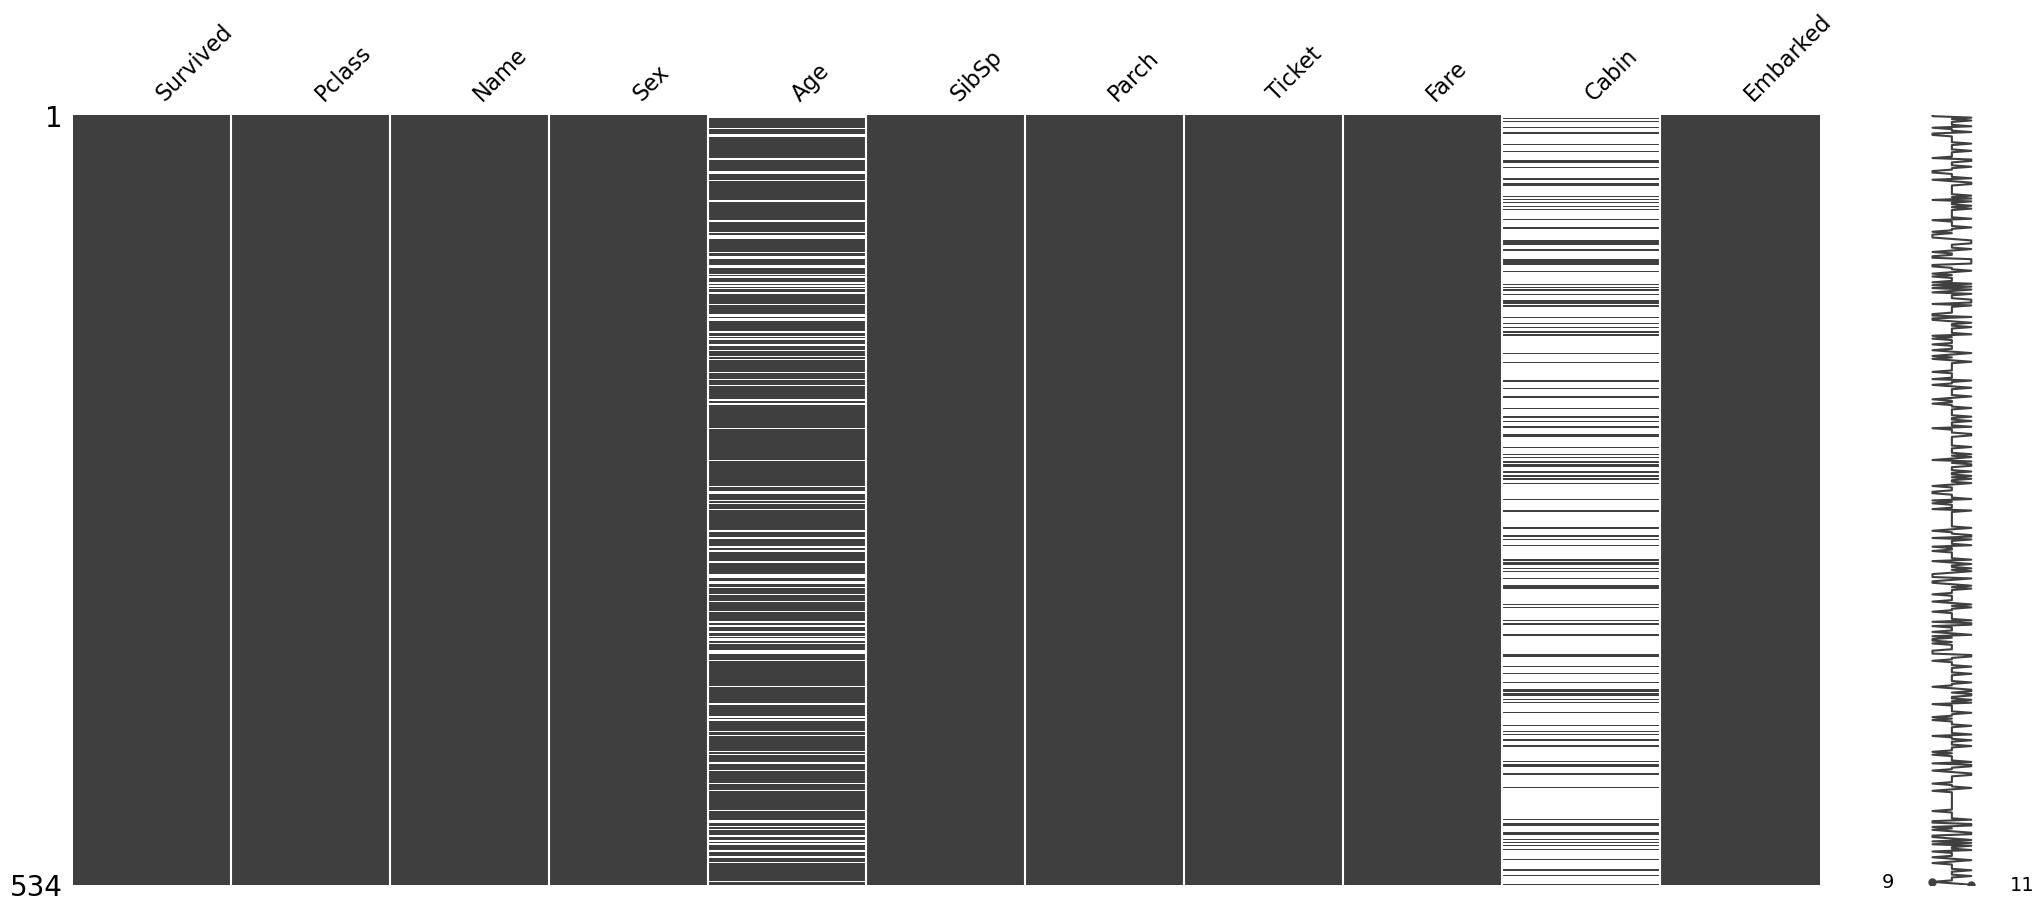

In [151]:
# Проверка пропусков
missingno.matrix(df)

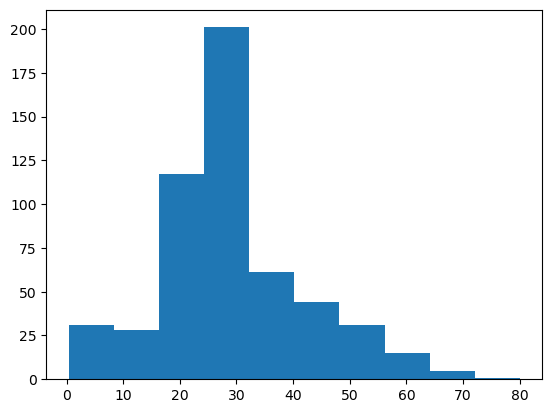

In [153]:
imp = KNNImputer(missing_values=np.nan)
df['Age'] = imp.fit_transform(df['Age'].values.reshape(-1, 1))
# df['Age'] = df['Age'].fillna(df['Age'].mean())
plt.hist(df['Age'])
plt.show()

In [154]:
# Удалим столбец Cabin
del df['Cabin']

In [155]:
# Удалим не нужные столбцы из data frame
df.drop(columns=['Name', 'Ticket', 'Fare'], inplace=True)

<Axes: >

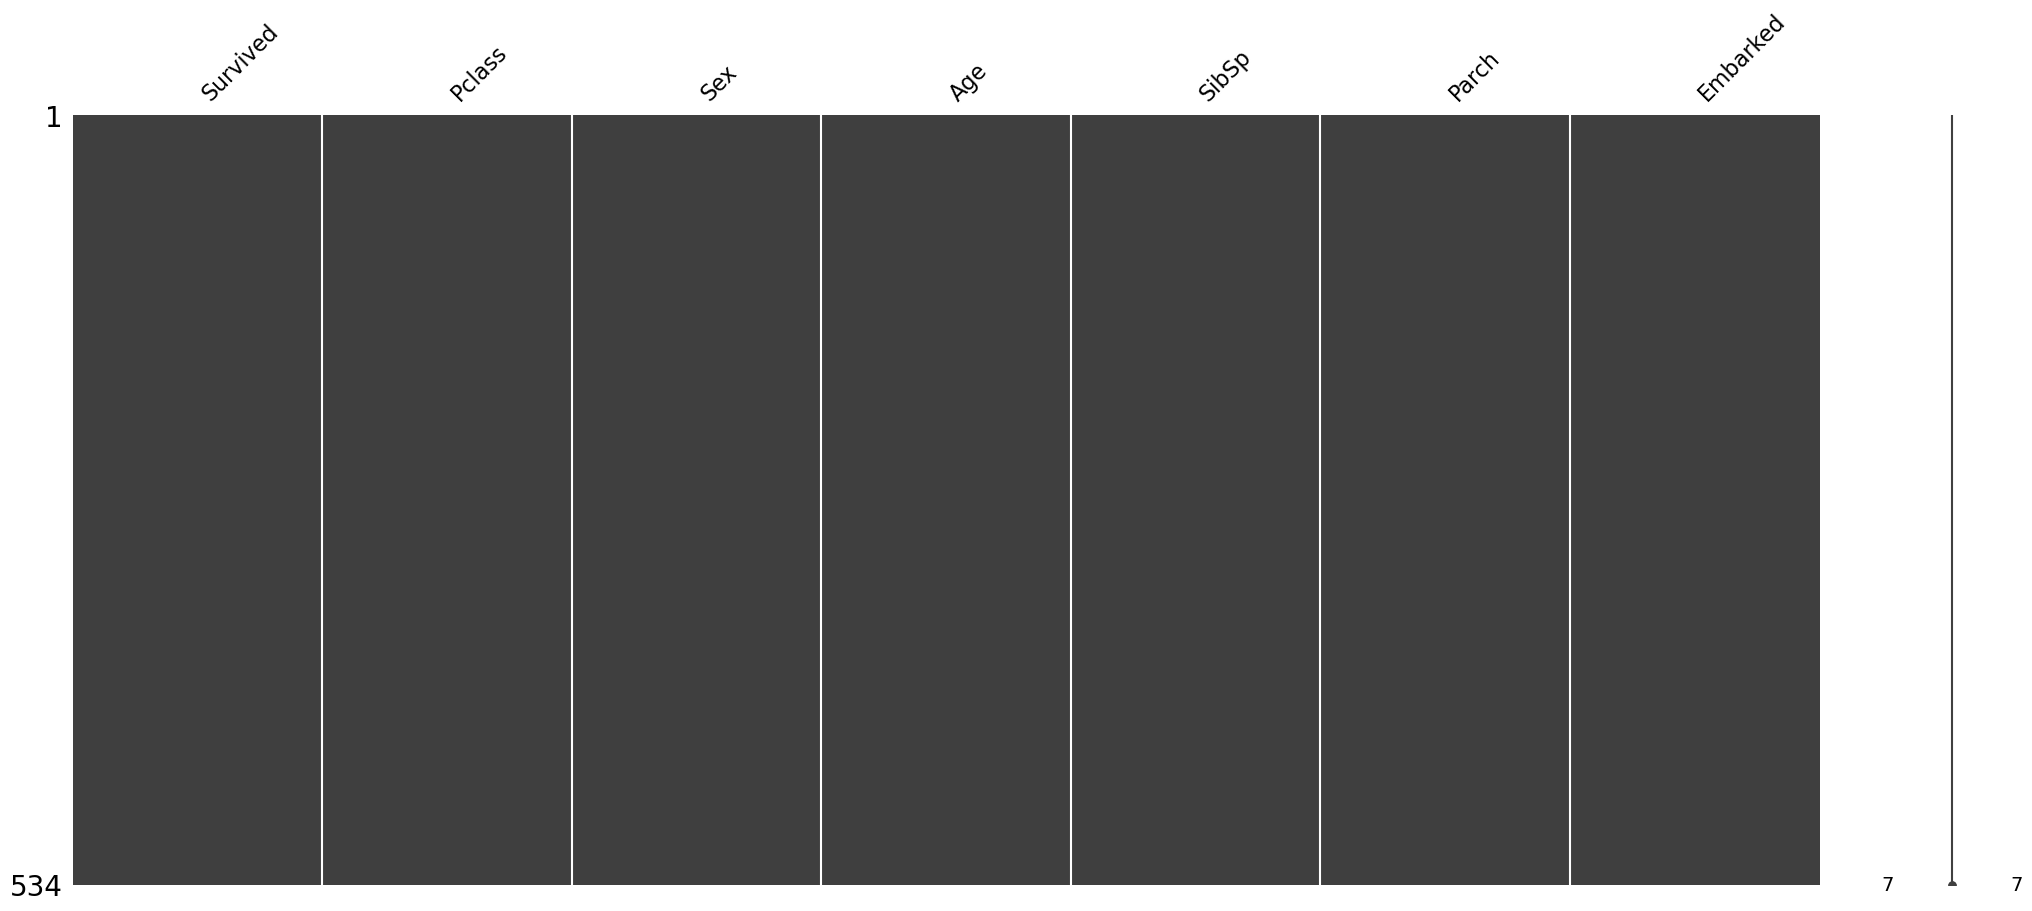

In [156]:
missingno.matrix(df)

In [157]:
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')
standard_scaler = StandardScaler()

In [158]:
# Удаление выбросов
def sigmaclip(d, s, low=4, high=4):
    mean = d[s].mean()
    std = d[s].std()
    return d[(d[s].isna()) | ((d[s] >= mean - std*low) & (d[s] <= mean + std*high))]

# df = sigmaclip(df, 'Fare')
# Применение OneHotEncoder к категориальным переменным
categorical_variables = ['Sex', 'Embarked']
transformed = one_hot_encoder.fit_transform(df[categorical_variables])
encoded = pd.DataFrame(transformed, index=df.index)
encoded.columns = one_hot_encoder.get_feature_names_out()
df = df.join(encoded)
df.drop(columns=['Sex', 'Embarked'], inplace=True)



In [159]:
# применение standard_scaler к числовым переменным
numeric_variables = ['Pclass', 'Age', 'SibSp', 'Parch']
df[numeric_variables] = standard_scaler.fit_transform(df[numeric_variables])

df.head()

,Survived,Pclass,Age,SibSp,Parch,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,,
486,0,0.801553,5.365425e-16,2.033165,0.757215,0.0,0.0,1.0
426,0,0.801553,5.365425e-16,-0.455094,-0.464395,1.0,0.0,1.0
780,1,-1.583011,1.010900e+00,-0.455094,0.757215,0.0,0.0,1.0
248,1,-0.390729,-4.238213e-01,-0.455094,1.978825,0.0,0.0,1.0
184,1,-0.390729,-2.160589e+00,1.203746,0.757215,1.0,0.0,1.0


## 3.Построение моделей классификаторов с параметрами, подобранными на перекрестной проверке (cross validation). 

In [160]:
models = {
    'logistic_regression': (
        LogisticRegression(solver='liblinear'),
        {
            'class_weight': ['balanced', None],
            'penalty': ['l1', 'l2'],
            'C': np.linspace(0.01, 10, 10)
        }
        ),
    'nearest_neighbors_method': (
        KNeighborsClassifier(),
        {
            'n_neighbors': range(1, 50)
        }
        ),
    'naive_bayes_classifier': (
        GaussianNB(),
        {
            'var_smoothing': np.linspace(1e-14, 1e-9, 100)
        }
        ),
    'linear_discriminan_analysis': (
        LinearDiscriminantAnalysis(),
        {
            'solver': ['svd', 'lsqr']
        }
        ),
    'quadratic_discriminant_analysis': (
        QuadraticDiscriminantAnalysis(),
        {
            'store_covariance': [True, False]
        }
        ),
    'support_vector_machine': (
        SVC(), 
        {
            'C': np.linspace(0.01, 10, 10),
            'kernel': ['rbf', 'sigmoid', 'poly', 'linear'],
            'gamma': ['scale', 'auto']
        }
        )   
}

In [161]:
y = df['Survived']
X = df.drop('Survived', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# Применение семплирования к данным
smote = SMOTE()
rs = RandomUnderSampler()
X_train, y_train = rs.fit_resample(X_train, y_train)

In [162]:
for model_name, (model, param_grid) in models.items():
    print('-'*45)
    print(model_name)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
    predictor = grid_search.fit(X_train, y_train)
    y_pred = predictor.best_estimator_.predict(X_test)
    print(f"Roc auc: {roc_auc_score(y_test, y_pred)}")
    print(f"Acc: {accuracy_score(y_test, y_pred)}")




---------------------------------------------
logistic_regression
Roc auc: 0.7741626794258374
Acc: 0.782608695652174
---------------------------------------------
nearest_neighbors_method
Roc auc: 0.7678628389154705
Acc: 0.7888198757763976
---------------------------------------------
naive_bayes_classifier
Roc auc: 0.7396331738437002
Acc: 0.7391304347826086
---------------------------------------------
linear_discriminan_analysis
Roc auc: 0.7665869218500798
Acc: 0.7763975155279503
---------------------------------------------
quadratic_discriminant_analysis
Roc auc: 0.776475279106858
Acc: 0.782608695652174
---------------------------------------------
support_vector_machine
Roc auc: 0.7573365231259968
Acc: 0.7763975155279503


### Как мы видим, лучше всех себя показывает алгоритм "Машина опорных векторов". <br> Поэтому будем использовать его

In [163]:
test_data = pd.read_csv('test.csv', index_col='PassengerId')
test_data['Age'] = imp.fit_transform(test_data['Age'].values.reshape(-1, 1))

del test_data['Cabin']
test_data.drop(columns=['Name', 'Ticket', 'Fare'], inplace=True)

transformed = one_hot_encoder.fit_transform(test_data[categorical_variables])
encoded = pd.DataFrame(transformed, index=test_data.index)
encoded.columns = one_hot_encoder.get_feature_names_out()
test_data = test_data.join(encoded)
test_data.drop(columns=['Sex', 'Embarked'], inplace=True)

test_data[numeric_variables] = standard_scaler.transform(test_data[numeric_variables])


In [164]:
test_data.drop('Embarked_nan', axis=1, inplace=True)

In [165]:
test_data.head()

,Pclass,Age,SibSp,Parch,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,
384,-1.583011,0.406807,0.374326,-0.464395,0.0,0.0,1.0
882,0.801553,0.255783,-0.455094,-0.464395,1.0,0.0,1.0
276,-1.583011,2.521133,0.374326,-0.464395,0.0,0.0,1.0
648,-1.583011,1.992551,-0.455094,-0.464395,1.0,0.0,0.0
224,0.801553,0.016529,-0.455094,-0.464395,1.0,0.0,1.0


In [166]:
main_model = [
    # SVC(),  {
    #     'C': np.linspace(0.01, 10, 10),
    #     'kernel': ['rbf', 'sigmoid', 'poly', 'linear'],
    #     'gamma': ['scale', 'auto']
    # }
    QuadraticDiscriminantAnalysis(),
    {
        'store_covariance': [True, False]
    }
        
]
estimator = GridSearchCV(estimator=main_model[0], cv=5, param_grid=main_model[1])
X = df.drop('Survived', axis=1)
y = df['Survived']
predictor = estimator.fit(X, y)
y_pred = predictor.best_estimator_.predict(test_data)
test_data['Survived'] = y_pred
test_data.head()

,Pclass,Age,SibSp,Parch,Sex_male,Embarked_Q,Embarked_S,Survived
PassengerId,,,,,,,,
384,-1.583011,0.406807,0.374326,-0.464395,0.0,0.0,1.0,1
882,0.801553,0.255783,-0.455094,-0.464395,1.0,0.0,1.0,0
276,-1.583011,2.521133,0.374326,-0.464395,0.0,0.0,1.0,1
648,-1.583011,1.992551,-0.455094,-0.464395,1.0,0.0,0.0,1
224,0.801553,0.016529,-0.455094,-0.464395,1.0,0.0,1.0,0


In [140]:
result_data = test_data['Survived']
result_data.to_csv('result.csv')